In [1]:
# Variables explaination link: https://api.census.gov/data/2010/dec/sf1/variables.html

"""
P001001	Total	TOTAL POPULATION	not required	P001001ERR	0	(not a predicate)	P1
P002001	Total	URBAN AND RURAL	not required	P002001ERR	0	int	P2
P002002	Total!!Urban	URBAN AND RURAL	not required		0	int	P2
P002003	Total!!Urban!!Inside urbanized areas	URBAN AND RURAL	not required		0	int	P2
P002004	Total!!Urban!!Inside urban clusters	URBAN AND RURAL	not required		0	int	P2
P002005	Total!!Rural	URBAN AND RURAL	not required		0	int	P2
P002006	Total!!Not defined for this file	URBAN AND RURAL	not required		0	int	P2
P003001	Total	RACE	not required	P003001ERR	0	int	P3
P003002	Total!!White alone	RACE	not required		0	int	P3
P003003	Total!!Black or African American alone	RACE	not required		0	int	P3
P003004	Total!!American Indian and Alaska Native alone	RACE	not required		0	int	P3
P003005	Total!!Asian alone	RACE	not required		0	int	P3
P003006	Total!!Native Hawaiian and Other Pacific Islander alone	RACE	not required		0	int	P3
P003007	Total!!Some Other Race alone	RACE	not required		0	int	P3
P003008	Total!!Two or More Races	RACE	not required		0	int	P3
P004001	Total	HISPANIC OR LATINO ORIGIN	not required	P004001ERR	0	int	P4
P004002	Total!!Not Hispanic or Latino	HISPANIC OR LATINO ORIGIN	not required		0	int	P4
P004003	Total!!Hispanic or Latino	HISPANIC OR LATINO ORIGIN
"""

# Dataset: https://api.census.gov/data/2010/dec/sf1?get=P001001,P003002,P003003,P004003,NAME&for=county:*
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

## 1 Load the dataset

In [2]:
df = pd.read_json("https://api.census.gov/data/2010/dec/sf1?get=P001001,P003002,P003003,P004003,NAME&for=county:*")


new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
new_header[0] = 'Total'
new_header[1] = 'White'
new_header[2] = 'Black'
new_header[3] = 'Hispanic or Latino'
df.columns = new_header #set the header row as the df header
df.head(10)

,Total,White,Black,Hispanic or Latino,NAME,state,county
1,125744,96344,8019,15445,"Sebastian County, Arkansas",05,131
2,17058,11949,734,5220,"Sevier County, Arkansas",05,133
3,17264,16582,93,290,"Sharp County, Arkansas",05,135
4,12394,11995,11,157,"Stone County, Arkansas",05,137
5,41639,26276,13721,1460,"Union County, Arkansas",05,139
6,17295,16598,68,475,"Van Buren County, Arkansas",05,141
7,203065,162253,6006,31458,"Washington County, Arkansas",05,143
8,77076,70425,3074,2879,"White County, Arkansas",05,145
9,22185,19226,307,4230,"Yell County, Arkansas",05,149
10,21419,13854,195,11804,"Colusa County, California",06,011


In [202]:
df[False == df['NAME'].str.contains("County")].head(10)

,Total,White,Black,Hispanic or Latino,NAME,state,county
107,97581,75175,4423,5651,"Fairbanks North Star Borough, Alaska",02,090
111,3141,660,219,385,"Aleutians East Borough, Alaska",02,013
112,5561,2004,332,726,"Aleutians West Census Area, Alaska",02,016
113,1826,1637,10,42,"Denali Borough, Alaska",02,068
114,4847,878,11,101,"Dillingham Census Area, Alaska",02,070
115,997,481,0,24,"Bristol Bay Borough, Alaska",02,060
177,601723,231471,305125,54749,"District of Columbia, District of Columbia",11,001
241,291826,192498,16226,22061,"Anchorage Municipality, Alaska",02,020
242,17013,1894,65,181,"Bethel Census Area, Alaska",02,050
243,13592,7522,92,996,"Kodiak Island Borough, Alaska",02,150


After some research, we can observe that for instance, we have the datas for Carson City, from Nevada.
This City is not part of any county (source: https://en.wikipedia.org/wiki/Carson_City,_Nevada). 
Those entries will simply not be used, since we only use Police Stops with a County_name column specified

In [206]:
# Given a county name and a state name, returns the number of 
# total polulation, number of blacks and number of whites.
def getStatsByCounty(countyName, stateName, df):
    # Split the NAME column in "County/City Name" and "State"
    new_df = df.copy()
    new_df[['County_name', 'State_name']] = df['NAME'].str.split(',', 1, expand=True)
    matches = new_df[new_df['County_name'].str.contains(countyName)].copy()
    if(len(matches) == 0):
        # Try to remove dots from the county name 
        # i.e. "St. Johns County" is "St Johns counts" in the police dataset
        matches = new_df[new_df['County_name'].str.replace('.', '').str.contains("(?i)"+countyName)].copy()
            
    matches = matches[matches['State_name'].str.contains("(?i)"+stateName)].copy()
    
    matches['Total'] = pd.to_numeric(matches['Total'])
    matches['White'] = pd.to_numeric(matches['White'])
    matches['Black'] = pd.to_numeric(matches['Black'])
    matches['Hispanic or Latino'] = pd.to_numeric(matches['Hispanic or Latino'])
    
    if(len(matches) == 0):
        print("[getStatsByCounty] Error: County not found: ", countyName, " ", stateName)
        return;
    if(len(matches) == 1):
        return {'total': matches['Total'].values[0], 
                'white': matches['White'].values[0],
                'black': matches['Black'].values[0], 
             #   'hispanicy or latino': (matches['Hispanic or Latino']/matches['Total']).values[0]
               }
    else:
        print("[getStatyByCount] Error: Too many matches: ", countyName)
        print(matches[['County_name', 'State_name']])
        return;



In [5]:
getStatsByCounty('new york', '', df)

{'total': 1585873, 'white': 911073, 'black': 246687}

## 2 Analisis of the stop rate

In [287]:
data = pd.read_csv('data/search_rates.csv', low_memory=False)

# Keep only black/white subject_race
data = data[(data['subject_race'] == 'white') | (data['subject_race'] == 'black')]
del data['search_rate']
del data['count_searched']
data.head(10)

,county_name,state,subject_race,total_stops
0,Abbeville County,SC,black,14077
3,Abbeville County,SC,white,25472
5,Adams County,WA,black,3126
8,Adams County,WA,white,68191
9,Aiken County,SC,black,103665
12,Aiken County,SC,white,172806
14,Alachua County,FL,black,13368
17,Alachua County,FL,white,33126
18,Allendale County,SC,black,20140
21,Allendale County,SC,white,13078


We can observe that the state in the police stops dataset is in the two letters Alpha code representation (i.e. AL). In the cencus dataset, the state columns contains the state name (i.e. Alabama).

A mapping dictionary has been found and used on github:https://gist.github.com/rogerallen/1583593



In [7]:
# From https://gist.github.com/rogerallen/1583593
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [289]:
data_states_mapped = data.copy()
# Replace the state names
data_states_mapped['state'] = data['state'].map(abbrev_us_state)
# Create the cencus column for the cencus datas
data_states_mapped['cencus'] = data_states_mapped.apply(lambda x: getStatsByCounty(x['county_name'], x['state'], df), axis=1)

# Display Thomas County state
data_states_mapped[data_states_mapped['county_name'] == 'Thomas County']

[getStatsByCounty] Error: County not found:  Claredon County   South Carolina
[getStatsByCounty] Error: County not found:  Claredon County   South Carolina
[getStatsByCounty] Error: County not found:  Dillion County   South Carolina
[getStatsByCounty] Error: County not found:  Dillion County   South Carolina
[getStatsByCounty] Error: County not found:  Thomas County   Florida


,county_name,state,subject_race,total_stops,cencus
652,Thomas County,Florida,white,1,None


We can observe that in the Florida dataset, there is one arrest in the Thomas County! This county is not in florida, but in Georgia, very close to the florida border. These entry will be removed. 
The "Dillion County" from the police stops dataset has been misspelled, the real county name is "Dillon County". Same for "Claredon County" which is "Clarendon County".

In [255]:
# Correct misspeled county_name cencus data
# Dillon County
data_states_mapped.loc[data_states_mapped['county_name'] == 'Dillion County', 'cencus'] = \
data_states_mapped[data_states_mapped['county_name'] == 'Dillion County'].apply(lambda x: getStatsByCounty('Clarendon County', x['state'], df), axis=1)
# Clarendon County
data_states_mapped.loc[data_states_mapped['county_name'] == 'Claredon County', 'cencus'] = \
data_states_mapped[data_states_mapped['county_name'] == 'Claredon County'].apply(lambda x: getStatsByCounty('Clarendon County', x['state'], df), axis=1)

# Remove NaN cencus data (for instance Thomas County not been found in the Florida cencus datas)
data_states_mapped = data_states_mapped[data_states_mapped['cencus'].notna()]

In [252]:
data_states_mapped.head(10)

,county_name,state,subject_race,search_rate,count_searched,total_stops,cencus
0,Abbeville County,South Carolina,black,0.026355,371,14077,"{'total': 25417, 'white': 17691, 'black': 7187}"
3,Abbeville County,South Carolina,white,0.016999,433,25472,"{'total': 25417, 'white': 17691, 'black': 7187}"
5,Adams County,Washington,black,0.038708,121,3126,"{'total': 18728, 'white': 11703, 'black': 109}"
8,Adams County,Washington,white,0.014826,1011,68191,"{'total': 18728, 'white': 11703, 'black': 109}"
9,Aiken County,South Carolina,black,0.035759,3707,103665,"{'total': 160099, 'white': 111457, 'black': 39..."
12,Aiken County,South Carolina,white,0.034333,5933,172806,"{'total': 160099, 'white': 111457, 'black': 39..."
14,Alachua County,Florida,black,0.033513,448,13368,"{'total': 247336, 'white': 172156, 'black': 50..."
17,Alachua County,Florida,white,0.011562,383,33126,"{'total': 247336, 'white': 172156, 'black': 50..."
18,Allendale County,South Carolina,black,0.060079,1210,20140,"{'total': 10419, 'white': 2465, 'black': 7672}"
21,Allendale County,South Carolina,white,0.081434,1065,13078,"{'total': 10419, 'white': 2465, 'black': 7672}"


In [253]:
getStatsByCounty('Alachua County', 'Florida', df)

{'total': 247336, 'white': 172156, 'black': 50282}

We will now extract the rate of black people stopped and the rate of white people stopped.

In [266]:
def extractRate(race, total_stops, cencus_data):
    if race == 'black':
        return total_stops/cencus_data['black']
    else:
        return total_stops/cencus_data['white']

rates = data_states_mapped.copy()
rates['race_stop_rate'] = data_states_mapped.apply(lambda x: extractRate(x['subject_race'], x['total_stops'], x['cencus']) , axis=1)
rates.head(5)

/home/yata/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,county_name,state,subject_race,search_rate,count_searched,total_stops,cencus,race_stop_rate
0,Abbeville County,South Carolina,black,0.026355,371,14077,"{'total': 25417, 'white': 17691, 'black': 7187}",1.958675
3,Abbeville County,South Carolina,white,0.016999,433,25472,"{'total': 25417, 'white': 17691, 'black': 7187}",1.439828
5,Adams County,Washington,black,0.038708,121,3126,"{'total': 18728, 'white': 11703, 'black': 109}",28.678899
8,Adams County,Washington,white,0.014826,1011,68191,"{'total': 18728, 'white': 11703, 'black': 109}",5.826797
9,Aiken County,South Carolina,black,0.035759,3707,103665,"{'total': 160099, 'white': 111457, 'black': 39...",2.634167


In [267]:
# Dataset cleaning
# Remove entries where the rate of black or white if "inf"
# That would mean that no black/white are registered in the cencus dataset
county_to_remove = rates[False == rates['race_stop_rate'].replace([np.inf, -np.inf], np.nan).notna()]['county_name'].values
length_before = len(rates);
rates = rates[False == rates['county_name'].isin(county_to_remove)]
print((length_before - len(rates))/2, " counties removed");

1.0  counties removed


In [291]:
# We now have the rate of black people stopped and the rate of white people stopped
# We will now compute the ratio of those two different rates
# ratio = r_white / w_black

# If we have ratio > 1:  The rate of white stopped is greater than the rate of black stopped
# If we have ration < 0: The rate of black stopped is greater than the rate of white stopped

def computeRatio(white_rate, black_rate):
    return white_rate / black_rate;

def extract_ratio(race, race_stop_rate):
    if(race.iloc[0] == 'white'):
        return computeRatio(race_stop_rate.iloc[0], race_stop_rate.iloc[1])
    else:
        return computeRatio(race_stop_rate.iloc[1], race_stop_rate.iloc[0])

def appl_merge_rows(x):
    ratio = extract_ratio(x['subject_race'], x['race_stop_rate'])
    return pd.Series({'total_stops':x['total_stops'].sum(), 'ratio':ratio, 'cencus': x['cencus'].values[0]})
    
ratios = rates.groupby('county_name').apply(lambda x: appl_merge_rows(x))

print("Number of Counties with white_stop_rate > black_stop_rate: ", len(ratios[ratios['ratio'] > 1]))
print("Number of Counties with white_stop_rate < black_stop_rate: ", len(ratios[ratios['ratio'] < 1]))

sns.distplot(biais)
plt.title('Distribution of the ratios')
plt.xlabel('Ratio')
plt.ylabel('Density')
plt.show()

ratios.head(10)

Number of Counties with white_stop_rate > black_stop_rate:  30
Number of Counties with white_stop_rate < black_stop_rate:  114


,total_stops,ratio,cencus
county_name,,,
Abbeville County,39549,0.735103,"{'total': 25417, 'white': 17691, 'black': 7187}"
Adams County,71317,0.203174,"{'total': 18728, 'white': 11703, 'black': 109}"
Aiken County,276471,0.588584,"{'total': 160099, 'white': 111457, 'black': 39..."
Alachua County,46494,0.723757,"{'total': 247336, 'white': 172156, 'black': 50..."
Allendale County,33218,2.021034,"{'total': 10419, 'white': 2465, 'black': 7672}"
Anderson County,460883,0.688229,"{'total': 187126, 'white': 149818, 'black': 30..."
Asotin County,12652,0.615928,"{'total': 21623, 'white': 20392, 'black': 92}"
Baker County,25096,0.433823,"{'total': 27115, 'white': 22686, 'black': 3680}"
Bamberg County,58487,1.315891,"{'total': 15987, 'white': 5770, 'black': 9837}"


Text(0, 0.5, 'Ratio: (white_stop_rate / black_stop_rate)')

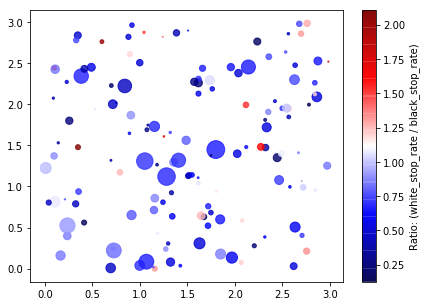

In [292]:
np.random.seed(142)

N = len(ratios)
x = np.random.rand(N)*3
y = np.random.rand(N)*3
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii


# standardize the total_stops for each county
total_stops = (ratios['total_stops']/ratios['total_stops'].mean())

plt.figure(figsize=(7, 5))

plt.scatter(x, y, alpha = .8, s=total_stops.values*50, c = ratios['ratio'].values, cmap = 'seismic')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Ratio: (white_stop_rate / black_stop_rate)')


Now we will observe how confident we are about those results.
The first step is to measure the biais.
Different formula can apply. Here, we will just apply:
$\sum_{\forall C\in\vec{Counties}} number\_of\_stops*(ratio - 1)$

$(ratio - 1)$ is positive if there the rate of white stops is greater than the rate of black stops

$(ratio - 1)$ is negative if there the rate of black stops is greater than the rate of white stops

We have decided that the number of data should influence the weight of the biais, this is why the **number_of_stops** is taken into account

In [299]:
# Compute the biais
def compute_biais(df):
    return df.apply(lambda x: x['total_stops'] * (x['ratio'] - 1), axis = 1).sum()

biais = compute_biais(ratios)
print("The biais in the ratios is: ", biais)
print("The mean of the ratios is: ", ratios['ratio'].mean())
print("The std of the ratios is: ", ratios['ratio'].std())

The biais in the ratios is:  -4471128.574947493
The mean of the ratios is:  0.7409052347706728
The std of the ratios is:  0.3757967199797347


This "huge" number does not mean much by itself. We can just observe that overall, with this negative number, we can make the hypothesis that the rate of black stops is greater than the rate of white stops. Furthermore, the mean lower than 1 embrace this hypothesis.

The second step is to generate a confidence interval of a **random** police stops.
For instance, in **"Abbeville County"**, there is $14077 + 25472 = 39 549$ police stops. There is also $17691 + 7187 = 24878$ black and white registered in the Cencus. You may note that the police stops is greater that the number of habitants registered in the Cencus dataset. This is because the police stops are over a period of many years. Furthermore, the Cencus may be imcomplete, and computed differently in different counties.
With a random police stop in **Abbeville County**, the probability to arrest a black person is $p = 7187/25878 = 0.29$.

The experience that we will run is that for **Abbeville County**, 39549 persons will be "stopped", with a probability $p$ to arrest a black person, and $1-p$ to arrest a white person. 
To summarize, for each County, we will create an artificial and random dataset of black and white random police stops, knowing the number of black and whites in that County.

Finally, we will compute the biais of each experience, as done in step 1.

In [302]:
import random
def create_random_df(cencus_df):
    def generate_black_white_stops(number_of_whites, number_of_blacks, total_stops):
        # p is the probability to pick a white person
        p = number_of_whites/(number_of_whites + number_of_blacks);
        blacks = 0;
        whites = 0;
        for i in range(total_stops):
            if(random.uniform(0, 1) < p):
                whites = whites + 1;
            else:
                blacks = blacks + 1;
                
        white_rate = extractRate('white', whites, {'white': number_of_whites,'black': number_of_blacks});
        black_rate = extractRate('black', blacks, {'white': number_of_whites,'black': number_of_blacks})
        
        return pd.Series({'total_stops':whites+blacks, 'ratio': computeRatio(white_rate, black_rate)});
    
    return cencus_df.apply(lambda x: generate_black_white_stops(x['cencus']['white'], x['cencus']['black'], x['total_stops']), axis = 1)

# Display a random DF
create_random_df(ratios.head(10)).head(10)

        

,total_stops,ratio
county_name,,
Abbeville County,39549.0,0.997825
Adams County,71317.0,0.974739
Aiken County,276471.0,0.993298
Alachua County,46494.0,0.996193
Allendale County,33218.0,0.997291
Anderson County,460883.0,0.998291
Asotin County,12652.0,1.052533
Baker County,25096.0,1.006252
Bamberg County,58487.0,1.005147


We can observe in the dataframe above a dataset of random arrests, generated with the Cencus datas. Each police stop is random among the population of the County.

In [308]:
# Compute the biais
def compute_biais_of_random_df(df):
    biais = df.apply(lambda x: x['total_stops']*(x['ratio'] - 1), axis = 1).sum()
    return biais

random_df = create_random_df(ratios);
biais = compute_biais_of_random_df(random_df)

print("The biais of the ratios is: ", biais)
print("The mean of the ratios is: ", random_df['ratio'].mean())
print("The std of the ratios is: ", random_df['ratio'].std())

The biais of the ratios is:  -20480.147385861907
The mean of the ratios is:  1.0034907478343364
The std of the ratios is:  0.05679686564035286


We can observe the biais of a random police stops dataset. We will create a sample of 1000 different police-stops dataset, and plot the distribution of the biais. We can also observe that the std is lower in this sample, and that the mean is as expected around 1.

In [197]:
def confidence_interval_datas(df):
    biais = [];
    for i in range(700):
        biais.append(compute_biais_of_random_df(create_random_df(df)))
    
    return biais

random.seed(42);
biais = confidence_interval_datas(ratios)

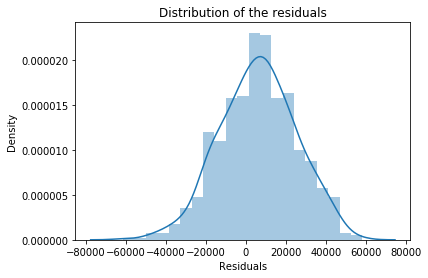

The confidence interval is [-32381.954983868694], 42286.82835519177]


In [199]:
sns.distplot(biais)
plt.title('Distribution of the residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

print(f'The confidence interval is [{np.nanpercentile(biais, 2.5)}], {np.nanpercentile(biais, 97.5)}]')

The observed biais in the real police stops dataset is outside of the confidence interval of the "racial unbiaised police stop datasets" generated with random police stops among the black and white population registered in the Cencus dataset. 